<a href="https://www.kaggle.com/code/zequanbear/scdnam-binary-mlp-private-lb-0-93100-5?scriptVersionId=244785809" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# scDNAm Single Cell Classification

这是我在 [scDNAm Single Cell Classification](https://www.kaggle.com/competitions/data-mining-2025-spring-homework-1/overview) 的比赛 Notebook , 最后我的结果提交的是这份代码产生的结果,我的主要思路是:通过捆绑二分类模型进行投票,以实现未知类识别. 感谢每个与我曾交流过的同学们, 你们的建议和对我建议的反馈都让我学习到了很多.

## 第三方库导入

In [1]:
!pip install anndata > /dev/null

In [2]:
# 生物信息数据处理
import anndata

# 表格数据和科学计算
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

# 机器学习与深度学习
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,BaggingClassifier,ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

# 标准库
import pickle as pkl
from copy import deepcopy
from collections import Counter

# 绘图方法
import matplotlib.pyplot as plt
import seaborn as sns

# 进度条
from tqdm import tqdm_notebook

# 过采样和欠采样方法
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# 警告过滤
import warnings
warnings.filterwarnings('ignore')

print("[INFO] 模块导入完成！")

[INFO] 模块导入完成！


In [3]:
train_data = anndata.read_h5ad("/kaggle/input/data-mining/train_adata.h5ad")
test_data = anndata.read_h5ad("/kaggle/input/data-mining/test_adata_noLabel.h5ad")

我们将数据类型稍微改动以节省内存.

In [4]:
train_data.X = train_data.X.astype(np.float32)
test_data.X = test_data.X.astype(np.float32)

In [5]:
X_train = train_data.X
y_train = train_data.obs['cell_type'].values

In [6]:
X_test = test_data.X
test_ids = test_data.obs_names.tolist()

## 缺失值补全

In [7]:
# 如果你想使用 KNNImputer ，可导入你已经训练好的 KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# with open('./knn_imputer.pkl', 'rb') as file:
#     imputer = pickle.load(file)

imputer = SimpleImputer(strategy = "mean")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [8]:
# 如果你使用 KNNImputer ，建议保存好模型以便节省时间
# with open("./knn_imputer.pkl",'wb') as f:
#     pkl.dump(imputer,f)

## 数据标准化（选做）

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

## PCA 降维

In [10]:
pca = PCA(n_components=50)

# 对 X_train_scaled 进行 PCA 变换
X_train_pca = pca.fit_transform(X_train_scaled)

# 查看每个主成分的解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_
print("每个主成分的解释方差比例:", explained_variance_ratio)

每个主成分的解释方差比例: [0.01527847 0.00741325 0.0046887  0.00297029 0.00265898 0.00235667
 0.00220958 0.00191524 0.00185377 0.00168668 0.00164664 0.00164264
 0.00161024 0.00155007 0.0015027  0.00148089 0.00146605 0.00141143
 0.00140322 0.00137039 0.00135213 0.00134544 0.0013201  0.00131515
 0.001302   0.00128721 0.00128387 0.00125382 0.00124884 0.00123724
 0.00122994 0.00121669 0.00120498 0.00119704 0.00119168 0.00118932
 0.0011837  0.00118012 0.00117539 0.00117343 0.00116855 0.00115676
 0.00114991 0.00114861 0.00114796 0.0011451  0.00113978 0.00113802
 0.00113684 0.00113246]


In [11]:
print("总解释方差比例:", sum(explained_variance_ratio))

总解释方差比例: 0.09446796413976699


In [12]:
X_test_pca = pca.transform(X_test_scaled)

PCA 的方差解释程度看着很低,但是对之后的训练足够了.

## SMOTE 过采样方法

In [13]:
smote = SMOTE(random_state=42,k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

In [14]:
category_counts = Counter(y_train_resampled)

# 输出每个类别对应的数量
for category, count in category_counts.items():
    print(f"类别 {category}: {count}")

类别 MSN-D1: 333
类别 IT-L5: 333
类别 MGE-Sst: 333
类别 NP-L6: 333
类别 IT-L6: 333
类别 MSN-D2: 333
类别 MGE-Pvalb: 333
类别 CT-L6: 333
类别 Foxp2: 333
类别 IT-L4: 333
类别 ASC: 333
类别 EP: 333
类别 CGE-Lamp5: 333
类别 MGC: 333
类别 PAL-Inh: 333
类别 Chd7: 333
类别 L6b: 333


In [15]:
y_train_resampled, texts = pd.factorize(y_train_resampled)

In [16]:
y_train_resampled

array([ 0,  0,  1, ..., 14, 14, 14])

## 基本模型：什么基本模型最合适？

In [17]:
# K 折交叉验证与 Cohen Kappa Score
kfold = StratifiedKFold(n_splits=5)
cohen = make_scorer(cohen_kappa_score)

下面我们讨论一个问题，如何选取二分类基础模型？我们通过训练来看什么样的模型具有最佳的交叉验证性能。

In [18]:
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in tqdm_notebook(classifiers):
    cv_results.append(cross_val_score(classifier, X_train_resampled, y = y_train_resampled, scoring = cohen, cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

  0%|          | 0/10 [00:00<?, ?it/s]

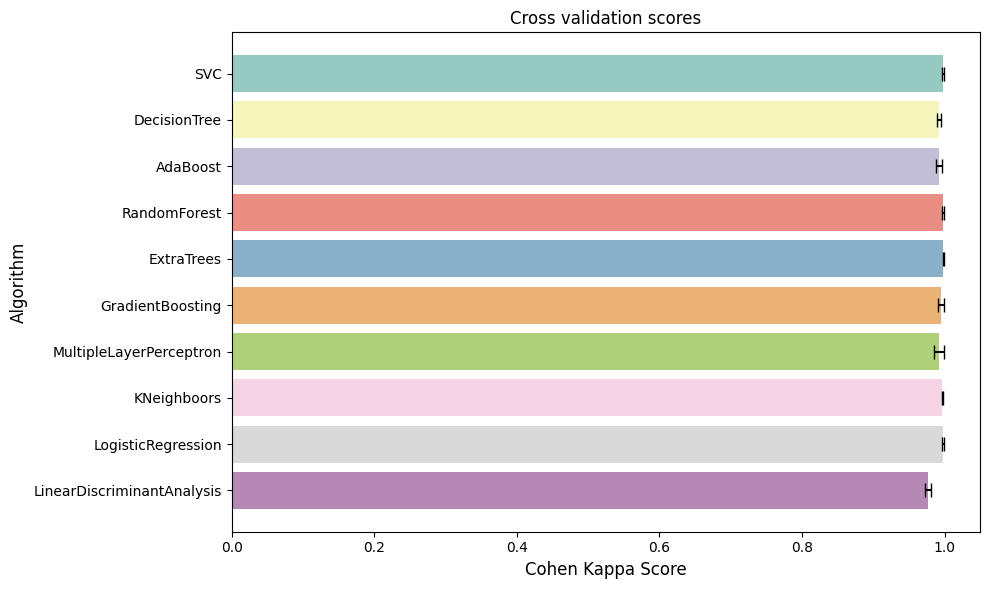

In [19]:
# 绘制条形图
plt.figure(figsize=(10, 6))
g = sns.barplot(
    y="Algorithm", 
    x="CrossValMeans", 
    data=cv_res, 
    palette="Set3", 
    orient="h"
)
plt.errorbar(
    x=cv_res["CrossValMeans"], 
    y=range(len(cv_res["Algorithm"])), 
    xerr=cv_res["CrossValerrors"], 
    fmt='none', 
    c='black', 
    capsize=5
)
g.set_xlabel("Cohen Kappa Score", fontsize=12)
g.set_ylabel("Algorithm", fontsize=12)
g.set_title("Cross Validation Scores", fontsize=14)
plt.tight_layout()
g = g.set_title("Cross validation scores")

不出意外的是，整体而言，都发生了明显的过拟合，基本都显著逼近 1.0 ，为了基本模型的一个准确性，我们不妨换成二分类的样本再尝试.

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

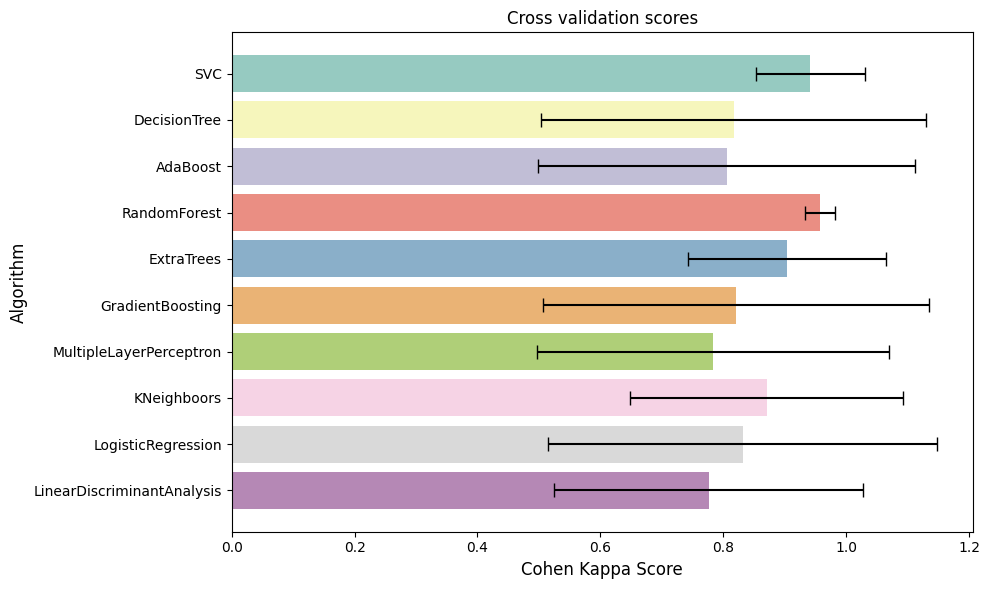

  0%|          | 0/10 [00:00<?, ?it/s]

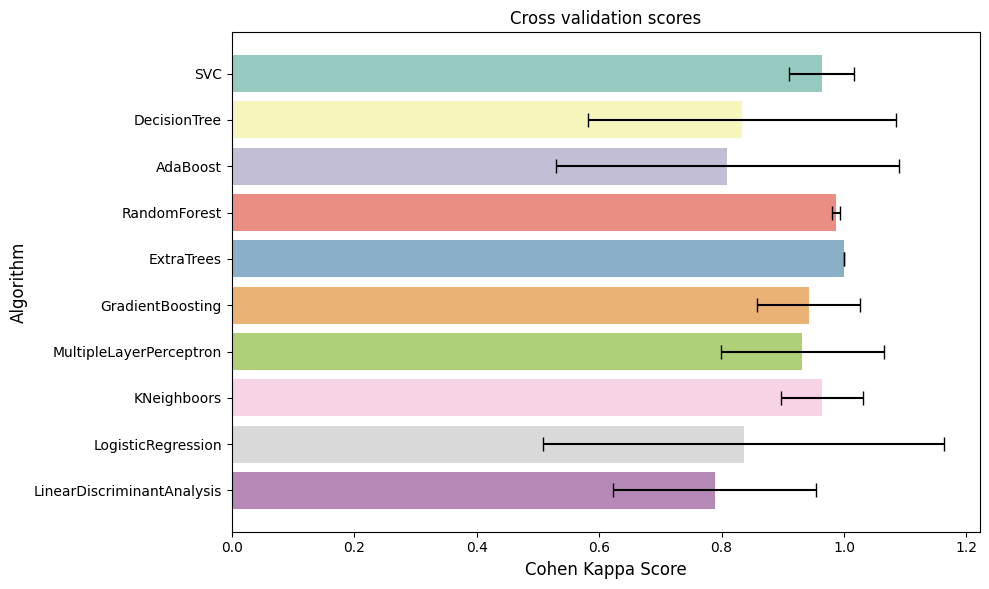

  0%|          | 0/10 [00:00<?, ?it/s]

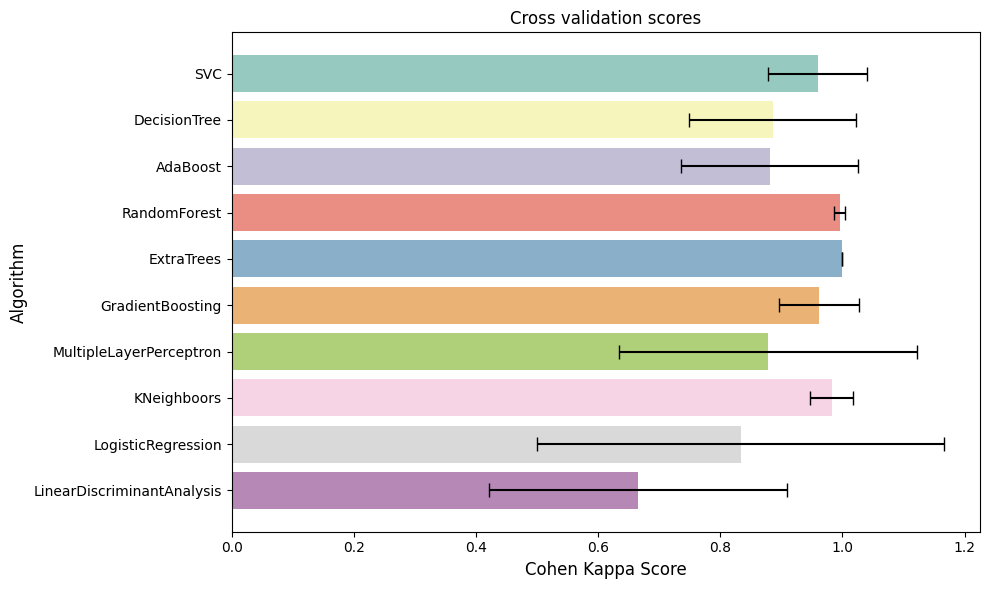

  0%|          | 0/10 [00:00<?, ?it/s]

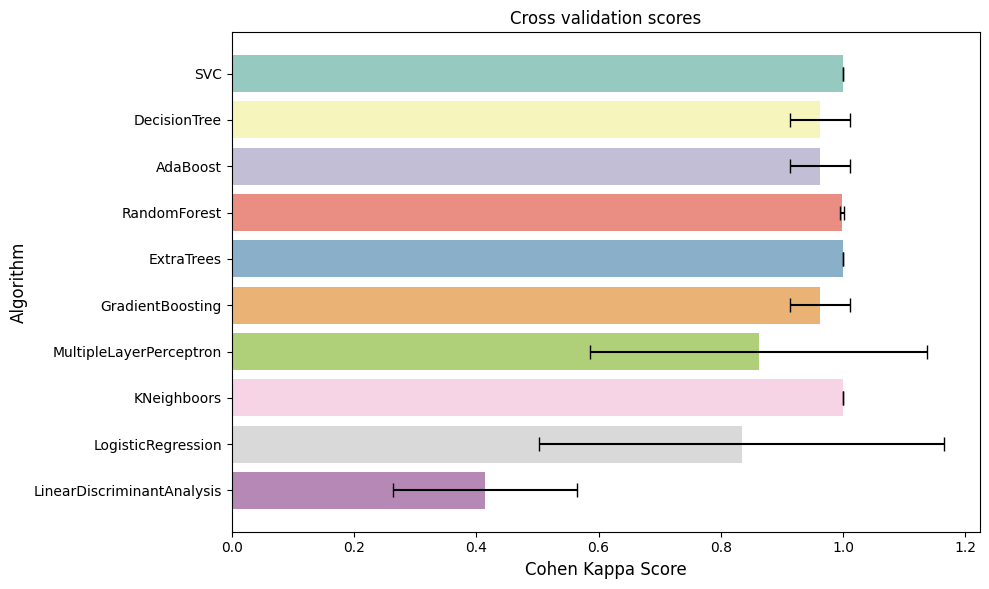

  0%|          | 0/10 [00:00<?, ?it/s]

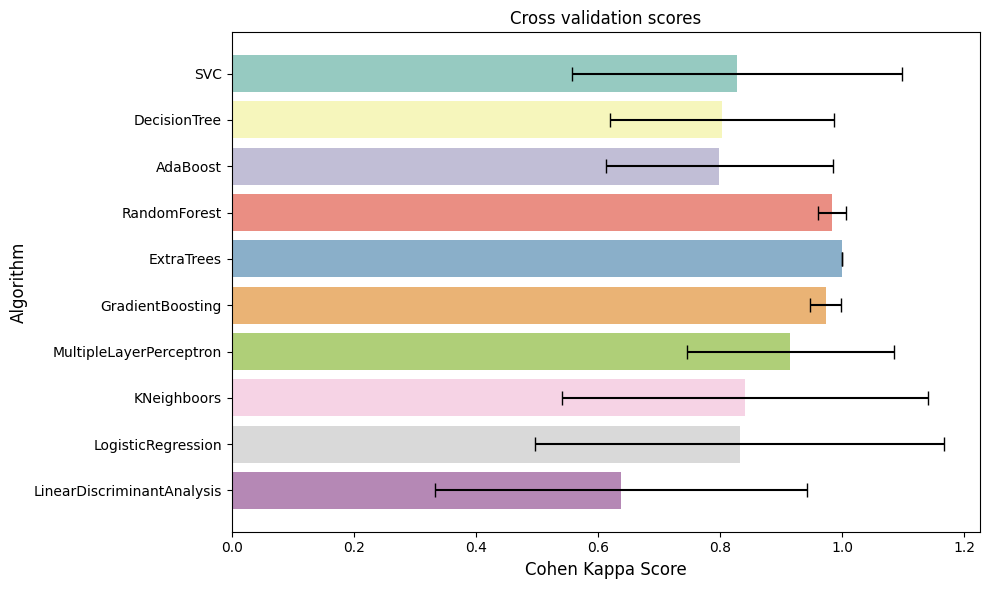

  0%|          | 0/10 [00:00<?, ?it/s]

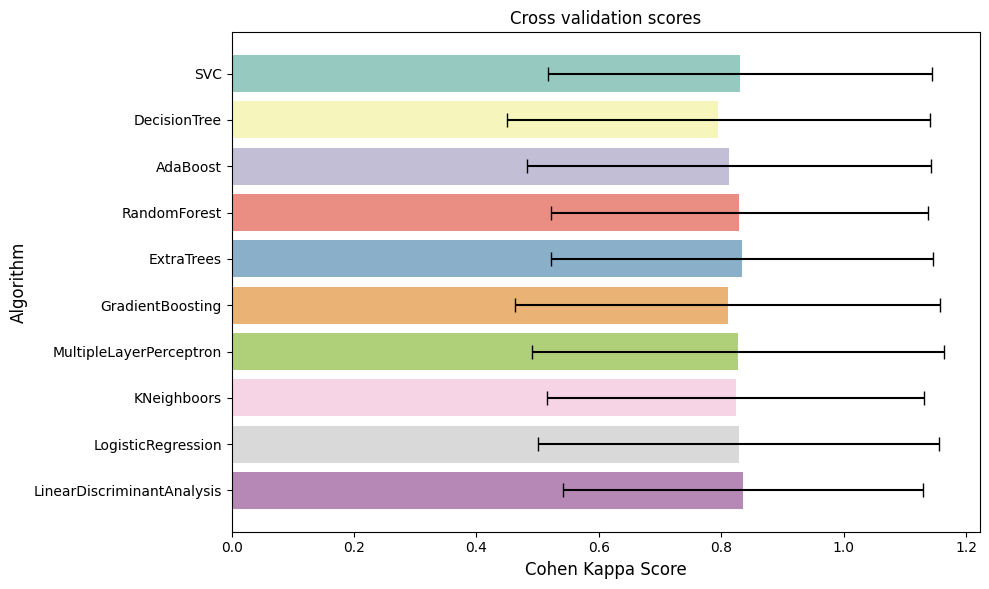

  0%|          | 0/10 [00:00<?, ?it/s]

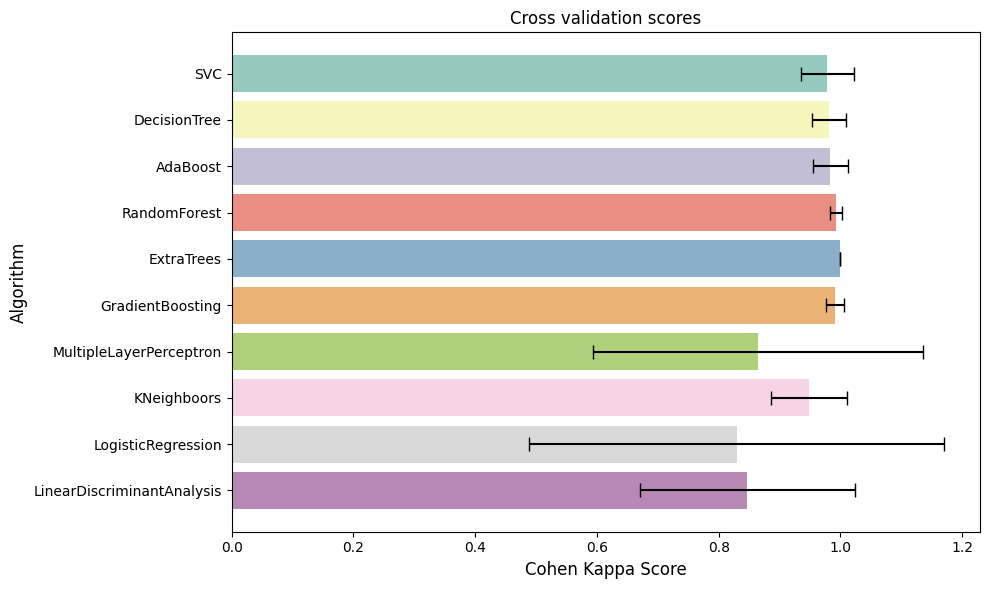

  0%|          | 0/10 [00:00<?, ?it/s]

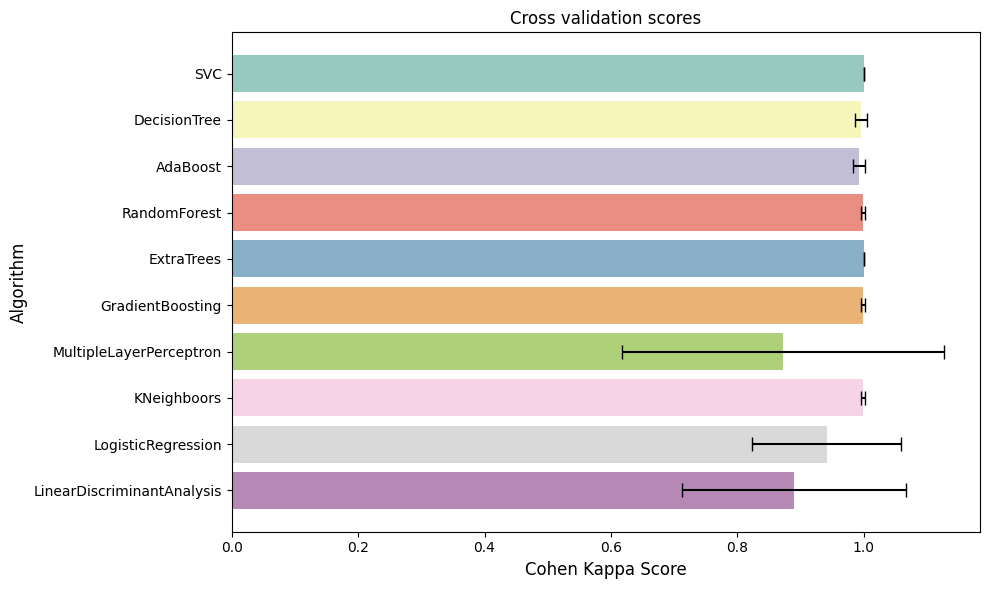

  0%|          | 0/10 [00:00<?, ?it/s]

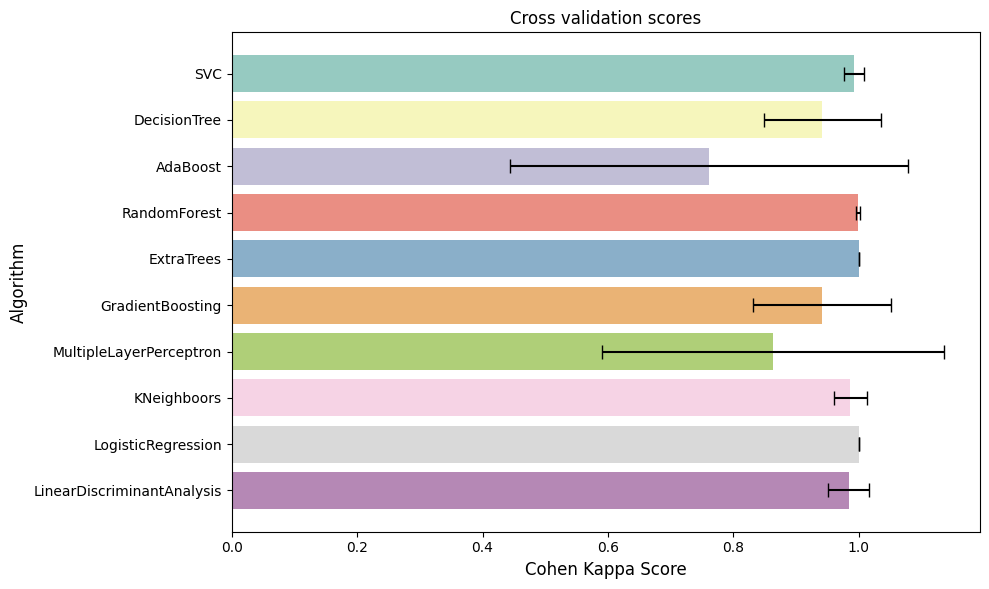

  0%|          | 0/10 [00:00<?, ?it/s]

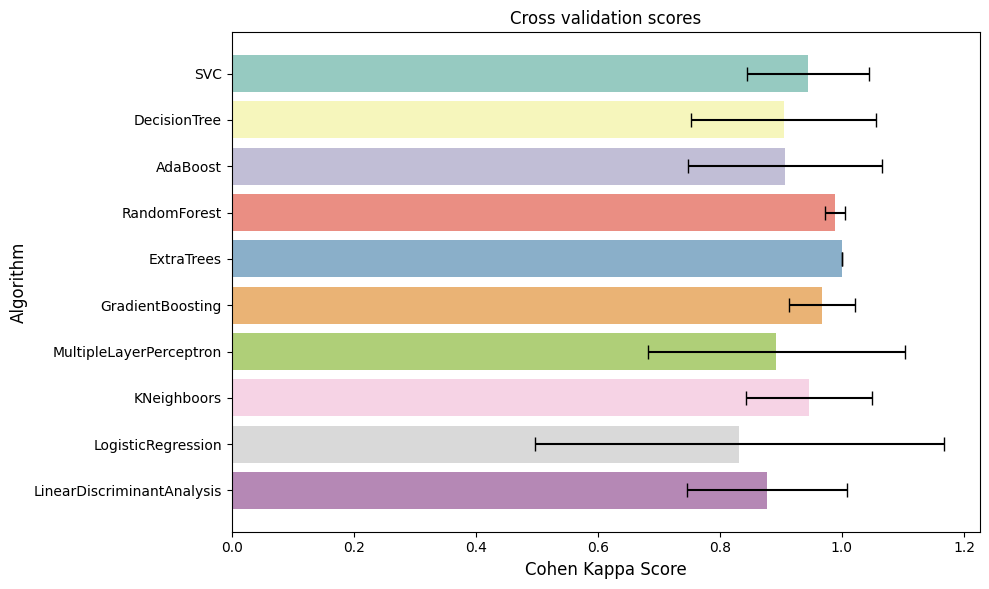

  0%|          | 0/10 [00:00<?, ?it/s]

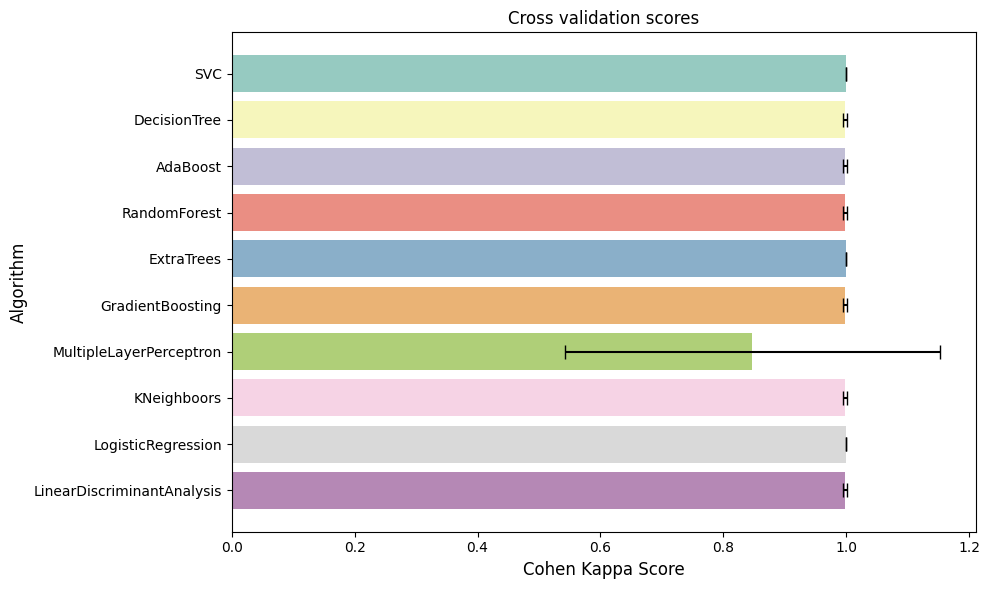

  0%|          | 0/10 [00:00<?, ?it/s]

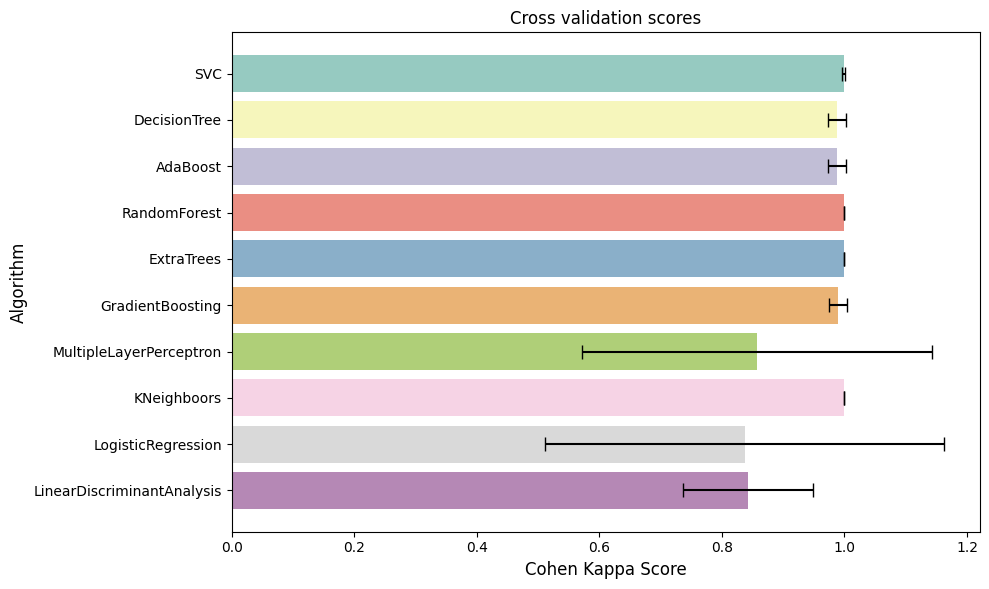

  0%|          | 0/10 [00:00<?, ?it/s]

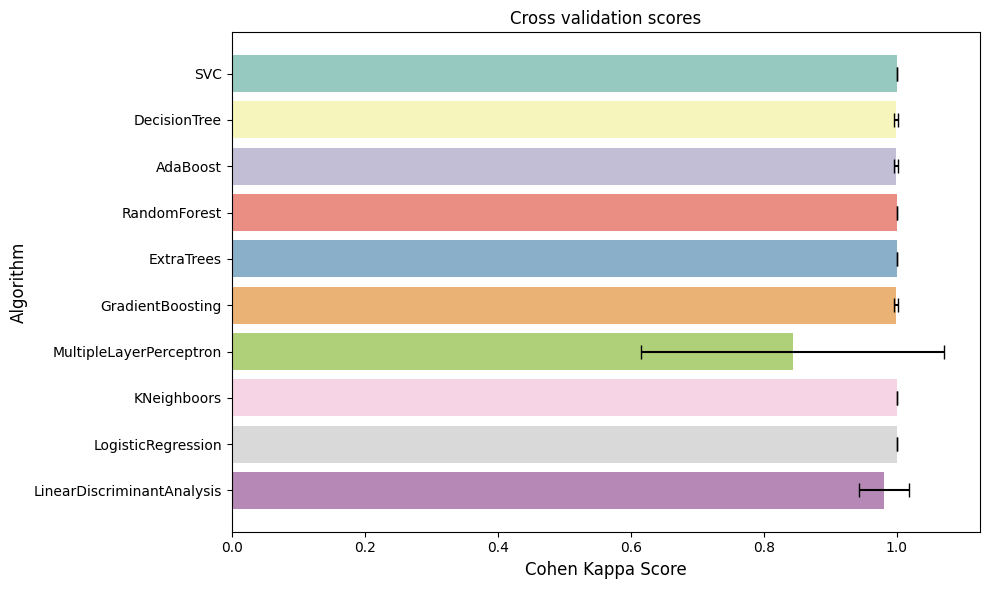

  0%|          | 0/10 [00:00<?, ?it/s]

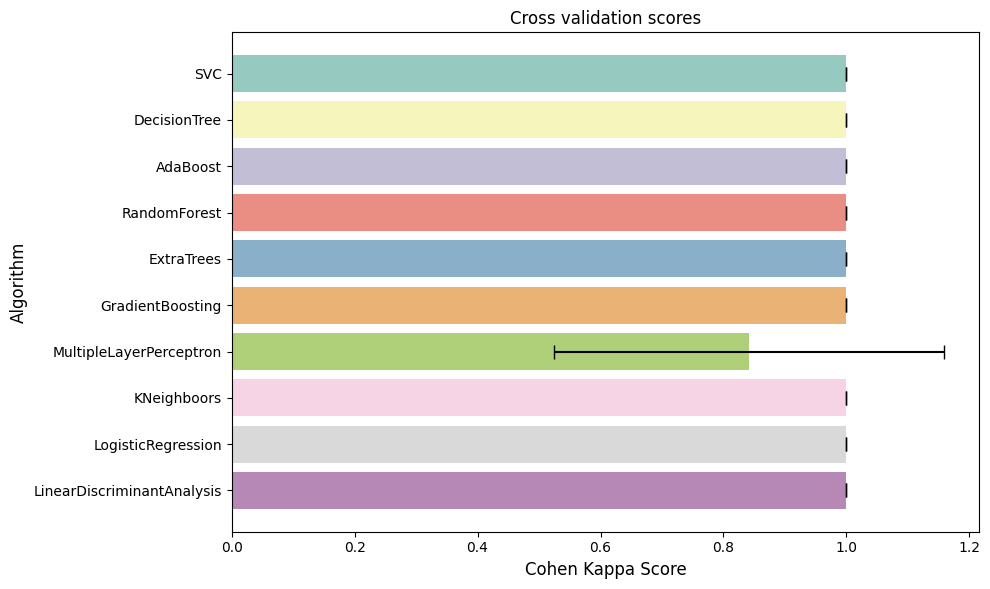

  0%|          | 0/10 [00:00<?, ?it/s]

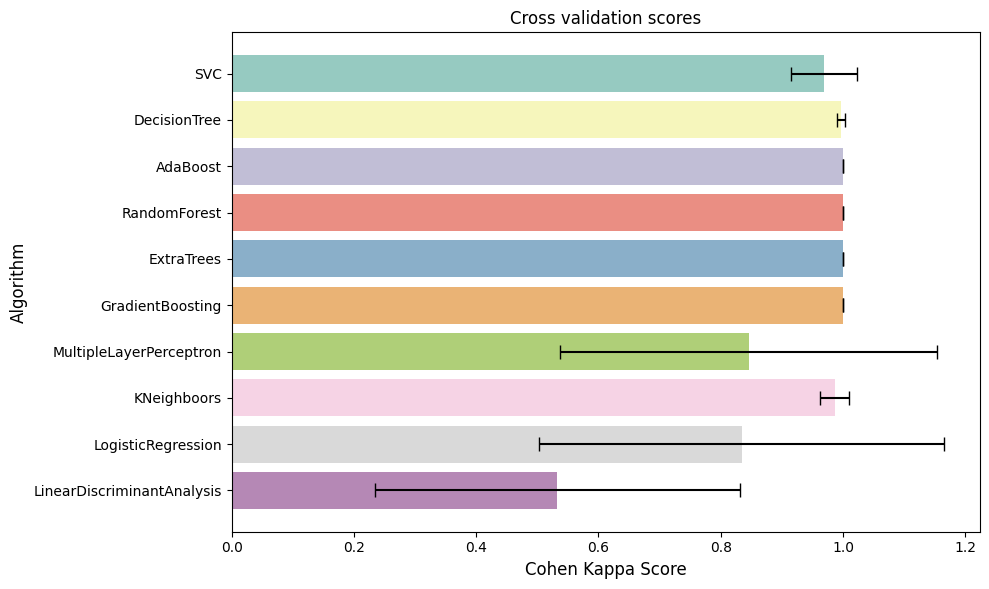

  0%|          | 0/10 [00:00<?, ?it/s]

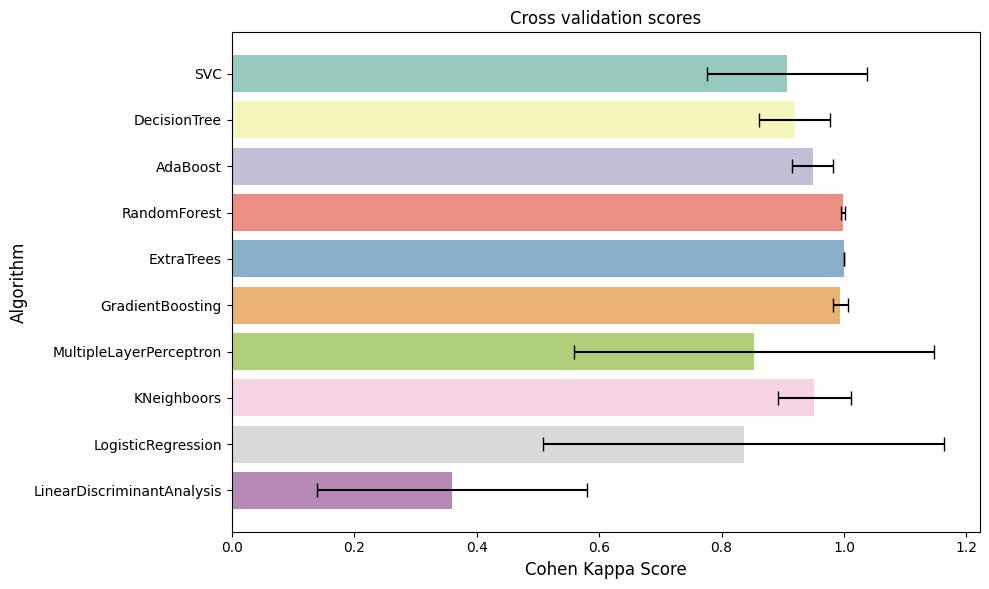

  0%|          | 0/10 [00:00<?, ?it/s]

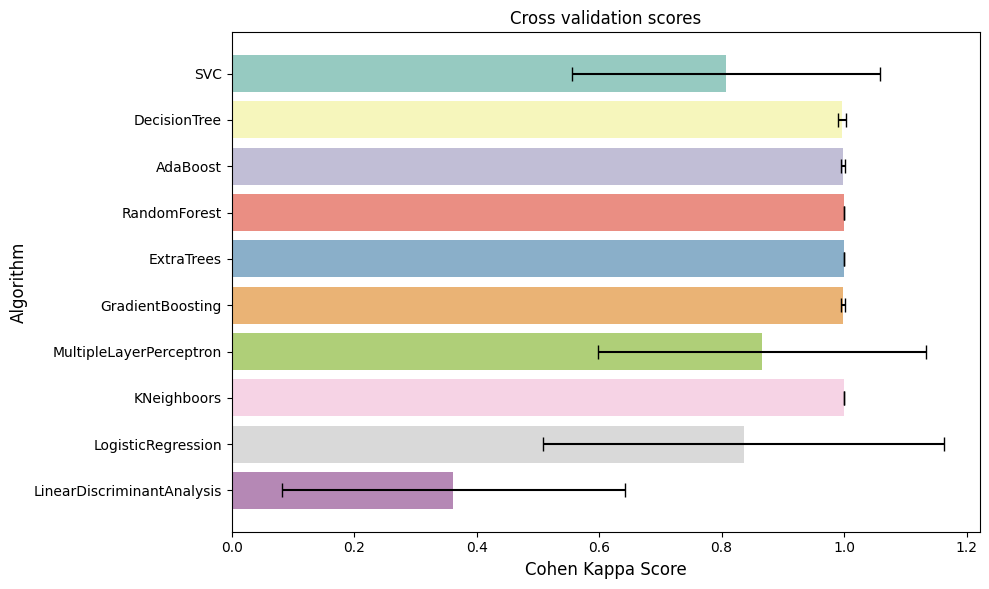

In [20]:
classes = np.unique(y_train_resampled)
for i in tqdm_notebook(range(len(classes))):
    y_temp = deepcopy(y_train_resampled)
    mask = (y_temp == classes[i])
    y_temp[mask] = 1
    y_temp[~mask] = 0
    
    random_state = 42
    classifiers = []
    classifiers.append(SVC(random_state=random_state))
    classifiers.append(DecisionTreeClassifier(random_state=random_state))
    classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
    classifiers.append(RandomForestClassifier(random_state=random_state))
    classifiers.append(ExtraTreesClassifier(random_state=random_state))
    classifiers.append(GradientBoostingClassifier(random_state=random_state))
    classifiers.append(MLPClassifier(hidden_layer_sizes=(128,64,32),activation='logistic',random_state=random_state))
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state = random_state))
    classifiers.append(LinearDiscriminantAnalysis())
    
    cv_results = []
    for classifier in tqdm_notebook(classifiers):
        cv_results.append(cross_val_score(classifier, X_train_resampled, y = y_temp, scoring = cohen, cv = kfold, n_jobs=-1))
    
    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())
    
    cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
    "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
    plt.figure(figsize=(10, 6))
    g = sns.barplot(
        y="Algorithm", 
        x="CrossValMeans", 
        data=cv_res, 
        palette="Set3", 
        orient="h"
    )
    plt.errorbar(
        x=cv_res["CrossValMeans"], 
        y=range(len(cv_res["Algorithm"])), 
        xerr=cv_res["CrossValerrors"], 
        fmt='none', 
        c='black', 
        capsize=5
    )
    g.set_xlabel("Cohen Kappa Score", fontsize=12)
    g.set_ylabel("Algorithm", fontsize=12)
    g.set_title("Cross Validation Scores", fontsize=14)
    plt.tight_layout()
    g = g.set_title("Cross validation scores")
    plt.show()

可以看到我们绘制的 17 张图像都出现了一个很大的波动,这表明我们在挑选二分类模型时需要进行慎重考虑,同时我们要注意几个特殊现象:

1. 第 6 种标签,所有的二分类模型都出现了较大的振幅,这种现象的原因是什么?我们尚且不得而知,但可以做的猜测是,这原来是少数样本,且非常特殊,SMOTE过采样将其放大,因此出现问题.
2. 线性模型普遍表现差,Logistic 和 线性判别分析都出现较大的波动,因此排除在外;
3. MLP 的表现很稳定,但是分数普遍低,原因可能是网络的设计问题,但是其波动范围大,有利于 LB 波动上分;
4. 树类模型都非常稳定,也基本不会出现分数的 shake , 比较适合稳定分数.

当然,我没有使用 XGBoost 或者 LightGBM 这样的模型,事实上它们应该会效果更好.

## MLP 二分类投票模型

接下来实践一个想法，如果我们对每个种类进行二分类，最后再进行投票，能否识别出未知类？目前我们是不知道的，可以进行一番实践. 出于对分数的考虑,我使用 MLP 来进行训练.

In [21]:
class TwoSidesClassifier():
    def __init__(self,base_estimator):
        # 只需给定一个分类器即可
        self.base_estimator = base_estimator
    
    def fit(self,X: np.ndarray,y: np.ndarray,verbose = 1):
        # 对每个模型进行训练

        target_num = np.unique(y).shape[0]
        self.target_num = target_num
        
        classes = np.unique(y)
        self.classes = classes
        
        self.base_estimators = [deepcopy(self.base_estimator) for _ in range(target_num)]
        
        for i in range(target_num):
            # 将其视为一种二分类模型
            # 先过滤 y 使得其仅有二分类
            if verbose:
                print(f"[INFO] 即将进行第 {i} 个模型的训练.")
            y_temp = deepcopy(y)
            mask = (y_temp == classes[i])
            y_temp[mask] = 1
            y_temp[~mask] = 0

            self.base_estimators[i].fit(X,y_temp)
        
        print('[INFO] 训练完成!')
        return self

    def predict(self,X):
        # 根据二分类模型进行预测
        # 如果有多个二分类模型认定其为 1，说明这是未知的.
        # 如果没有二分类模型认定为 1，也说明是未知的.

        predictions = []
        result = []
        for estimator in self.base_estimators:
            predictions.append(estimator.predict(X))

        self.base_predictions = np.array(predictions).T

        for p in self.base_predictions:
            if np.unique(p).shape[0] == 1 or np.count_nonzero(p) > 1:
                result.append(-1)
            else:
                for i in range(self.target_num):
                    if p[i] == 1:
                        result.append(i)
                        break

        return result


固定随机数，给定 MLP 分类器，

In [22]:
base = MLPClassifier(random_state=42,hidden_layer_sizes=(128,64,32), 
                     activation='logistic', solver='adam')

In [23]:
model = TwoSidesClassifier(base)

In [24]:
model.fit(X_train_resampled,y_train_resampled)

[INFO] 即将进行第 0 个模型的训练.
[INFO] 即将进行第 1 个模型的训练.
[INFO] 即将进行第 2 个模型的训练.
[INFO] 即将进行第 3 个模型的训练.
[INFO] 即将进行第 4 个模型的训练.
[INFO] 即将进行第 5 个模型的训练.
[INFO] 即将进行第 6 个模型的训练.
[INFO] 即将进行第 7 个模型的训练.
[INFO] 即将进行第 8 个模型的训练.
[INFO] 即将进行第 9 个模型的训练.
[INFO] 即将进行第 10 个模型的训练.
[INFO] 即将进行第 11 个模型的训练.
[INFO] 即将进行第 12 个模型的训练.
[INFO] 即将进行第 13 个模型的训练.
[INFO] 即将进行第 14 个模型的训练.
[INFO] 即将进行第 15 个模型的训练.
[INFO] 即将进行第 16 个模型的训练.
[INFO] 训练完成!


然后我们输出训练结果.

In [25]:
predict = model.predict(X_test_pca)
predict

[5,
 -1,
 7,
 6,
 4,
 -1,
 12,
 5,
 0,
 5,
 0,
 -1,
 8,
 12,
 9,
 8,
 -1,
 5,
 0,
 6,
 5,
 5,
 0,
 0,
 0,
 0,
 5,
 5,
 -1,
 4,
 -1,
 0,
 0,
 1,
 1,
 0,
 0,
 8,
 -1,
 -1,
 5,
 1,
 8,
 5,
 0,
 1,
 0,
 -1,
 5,
 0,
 0,
 2,
 5,
 0,
 0,
 -1,
 5,
 9,
 5,
 5,
 8,
 0,
 1,
 8,
 0,
 5,
 4,
 3,
 0,
 5,
 9,
 8,
 12,
 5,
 0,
 0,
 0,
 1,
 1,
 5,
 0,
 5,
 -1,
 5,
 1,
 -1,
 5,
 5,
 5,
 5,
 5,
 -1,
 0,
 14,
 -1,
 7,
 0,
 5,
 8,
 -1,
 7,
 0,
 12,
 -1,
 -1,
 0,
 5,
 0,
 5,
 4,
 0,
 11,
 0,
 7,
 0,
 5,
 1,
 0,
 5,
 5,
 0,
 -1,
 5,
 0,
 -1,
 5,
 11,
 1,
 0,
 0,
 12,
 0,
 0,
 5,
 7,
 12,
 0,
 0,
 5,
 5,
 0,
 9,
 0,
 0,
 16,
 0,
 8,
 5,
 0,
 0,
 9,
 -1,
 1,
 0,
 -1,
 12,
 0,
 5,
 12,
 5,
 5,
 0,
 0,
 0,
 5,
 -1,
 0,
 7,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 5,
 0,
 5,
 0,
 5,
 0,
 1,
 5,
 9,
 5,
 0,
 -1,
 5,
 1,
 5,
 0,
 1,
 0,
 5,
 0,
 8,
 7,
 5,
 5,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 0,
 5,
 -1,
 1,
 8,
 2,
 7,
 5,
 5,
 1,
 7,
 0,
 12,
 0,
 13,
 7,
 1,
 5,
 6,
 1,
 5,
 -1,
 5,
 -1,
 7,
 12,
 2,
 4,
 0,
 5,
 1,
 5,
 0,


最后我们反解码,将最后结果输出.

In [26]:
def decode(arr, code):
    decoded = []
    for class_ in arr:
        if class_ == -1:
            decoded.append('Unknown')  # 特殊类别 -1 保持不变
        else:
            decoded.append(code[class_])
    return np.array(decoded)

In [27]:
y_pred = decode(predict,texts)
y_pred

array(['MSN-D2', 'Unknown', 'CT-L6', 'MGE-Pvalb', 'IT-L6', 'Unknown',
       'CGE-Lamp5', 'MSN-D2', 'MSN-D1', 'MSN-D2', 'MSN-D1', 'Unknown',
       'Foxp2', 'CGE-Lamp5', 'IT-L4', 'Foxp2', 'Unknown', 'MSN-D2',
       'MSN-D1', 'MGE-Pvalb', 'MSN-D2', 'MSN-D2', 'MSN-D1', 'MSN-D1',
       'MSN-D1', 'MSN-D1', 'MSN-D2', 'MSN-D2', 'Unknown', 'IT-L6',
       'Unknown', 'MSN-D1', 'MSN-D1', 'IT-L5', 'IT-L5', 'MSN-D1',
       'MSN-D1', 'Foxp2', 'Unknown', 'Unknown', 'MSN-D2', 'IT-L5',
       'Foxp2', 'MSN-D2', 'MSN-D1', 'IT-L5', 'MSN-D1', 'Unknown',
       'MSN-D2', 'MSN-D1', 'MSN-D1', 'MGE-Sst', 'MSN-D2', 'MSN-D1',
       'MSN-D1', 'Unknown', 'MSN-D2', 'IT-L4', 'MSN-D2', 'MSN-D2',
       'Foxp2', 'MSN-D1', 'IT-L5', 'Foxp2', 'MSN-D1', 'MSN-D2', 'IT-L6',
       'NP-L6', 'MSN-D1', 'MSN-D2', 'IT-L4', 'Foxp2', 'CGE-Lamp5',
       'MSN-D2', 'MSN-D1', 'MSN-D1', 'MSN-D1', 'IT-L5', 'IT-L5', 'MSN-D2',
       'MSN-D1', 'MSN-D2', 'Unknown', 'MSN-D2', 'IT-L5', 'Unknown',
       'MSN-D2', 'MSN-D2', 'MSN-D2', 

我们做到了!最后将结果输出就好.

In [28]:
submission = pd.DataFrame({
    'ID': range(283),
    'TARGET': y_pred
})
submission.to_csv("./Binary-MLP-Sigmoid-Seed-42.csv",index=False)